# Application of L2 Regularization.
- The point of this exercise is to show how L2 regularization is used.
- The L2 lambda value will be parametrically varied to study how the model behaves as this value is changed.

In [46]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load the dataloader
from torch.utils.data import DataLoader, TensorDataset

# importing iris dataset
import seaborn as sns
iris_dataset = sns.load_dataset('iris')

### Transforming and Loading Data

In [47]:
# converting from pandas dataframe to pytorch tensor
torched_iris_dataset= torch.tensor(iris_dataset[iris_dataset.columns[0:4]].values).float() # only use first 4 columns, because last column is outcome variable or datatype.

# numeric transformation - transforming species name to a number (0-2)
iris_labels = torch.zeros(len(torched_iris_dataset), dtype=torch.long) # species 'setosa' will remain 0.
iris_labels[iris_dataset.species=='versicolor'] = 1
iris_labels[iris_dataset.species=='virginica'] = 2

In [48]:
# splitting iris dataset into training and testing
train_data, test_data, train_labels, test_labels = train_test_split(torched_iris_dataset, iris_labels, train_size= 0.8)

# converting to torch tensors, grouping data and labels
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# creating data loaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, shuffle=True, batch_size= test_data.tensors[0].shape[0])

### Function to Create Model

In [49]:
def create_ANN_model(L2_lambda):
    
    # model architecture
    ANN_model = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )

    # loss function
    loss_function = nn.CrossEntropyLoss()

    # optimizer, this is where L2 penalty is applied
    optimizer = torch.optim.SGD(ANN_model.parameters(), lr=0.005, weight_decay=L2_lambda)

    return ANN_model, loss_function, optimizer

### Function to Train Model
- Don't need to toggle model between `train` and `eval` modes because there is no batch normalization or dropout.

In [50]:
def batch_train_model(number_of_epochs, ANN_iris, loss_function, optimizer):
    
    training_accuracy_ary = []
    testing_accuracy_ary = []
    losses_ary = []

    # loop over epochs
    for epoch_IDX in range(number_of_epochs):

        batch_accuracy = []
        batch_loss = []

        for batch, labels in train_loader:
        # forward pass and calculate loss
            y_hat = ANN_iris(batch)
            loss = loss_function(y_hat, labels)

            # backpropagation (learning)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # calculate accuracy for current batch
            batch_accuracy.append(100*torch.mean((torch.argmax(y_hat, axis=1) == labels).float()).item())

            # batch losses
            batch_loss.append(loss.item())

        # calculate overall training accuracy and loss
        training_accuracy_ary.append(np.mean(batch_accuracy))
        losses_ary.append(np.mean(batch_loss))

        # Cross Validation of Model
        X_data, y_labels = next(iter(test_loader)) # there is only one batch, so there's no need for a for loop
        predicted_testing_labels = torch.argmax(ANN_iris(X_data),axis=1)

        # calculate testing accuracy
        testing_accuracy_ary.append(100*torch.mean((predicted_testing_labels == y_labels).float()).item())

    return training_accuracy_ary, testing_accuracy_ary, losses_ary

#### Quick test of model and training.

In [51]:
# model params
L2 = 0.01
num_epochs = 1000

# creating and training model
ANN_iris, loss_function, optimizer = create_ANN_model(L2)
training_acc, test_acc, losses = batch_train_model(num_epochs, ANN_iris, loss_function, optimizer)

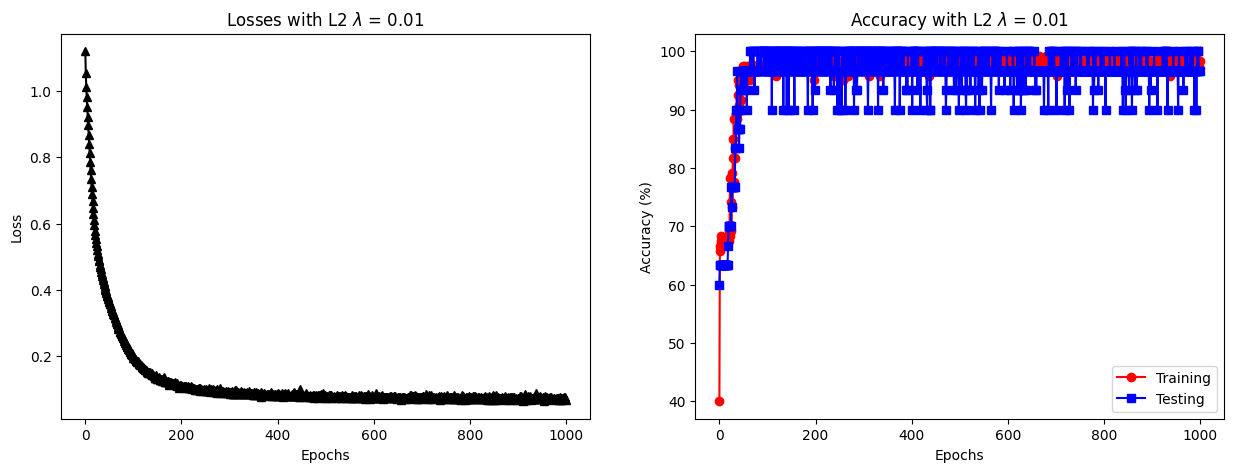

In [52]:
# plotting results
fig, ax = plt.subplots(1,2, figsize = (15,5))

# losses plot
ax[0].plot(losses, 'k^-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Losses with L2 $\lambda$ = {L2}')

# accuracy plot
ax[1].plot(training_acc, 'ro-')
ax[1].plot(test_acc, 'bs-')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Accuracy with L2 $\lambda$ = {L2}')
ax[1].legend(['Training', 'Testing'])

In [53]:
# smoothing function
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode= 'same')

---
# Parametric Experiment! 
- #### Varying the L2 $\lambda$ variable to study how accuracy is affected.

In [54]:
# experiment params
L2_lambdas = np.linspace(0, 0.1, 10)

accuracy_training = np.zeros((num_epochs, len(L2_lambdas)))
accuracy_test = np.zeros((num_epochs, len(L2_lambdas)))

# loop over lambda values
for lambda_IDX in range(len(L2_lambdas)):

    # create and train model
    ANN_iris, loss_function, optimizer = create_ANN_model(L2_lambdas[lambda_IDX])
    training_acc, test_acc, losses = batch_train_model(num_epochs, ANN_iris, loss_function, optimizer)

    # storing results
    accuracy_training[:,lambda_IDX] = smooth(training_acc, 5)
    accuracy_test[:,lambda_IDX] = smooth(test_acc, 5)

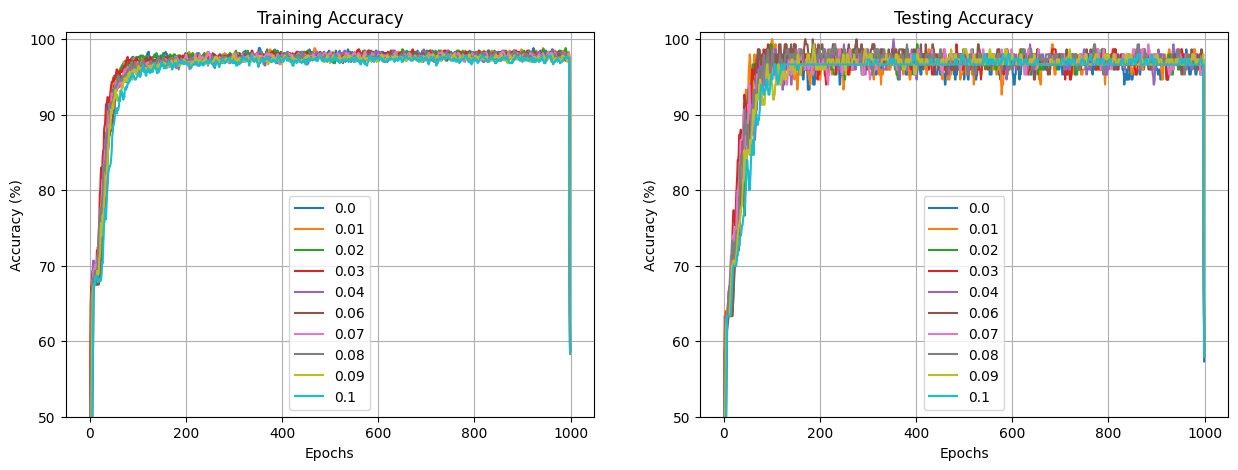

In [55]:
# plotting results
fig, ax = plt.subplots(1, 2, figsize = (15,5))

ax[0].plot(accuracy_training)
ax[0].set_title('Training Accuracy')

ax[1].plot(accuracy_test)
ax[1].set_title('Testing Accuracy')

# legend labels
legend_labels = [np.round(i,2) for i in L2_lambdas]

for i in range(2):
    ax[i].legend(legend_labels)
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

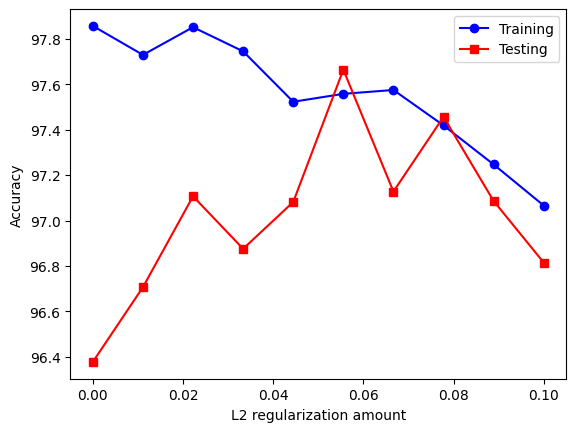

In [56]:
# limiting range of accuracy that is being plotted
epoch_range = [150, 600]

# averaging accuracies and plotting
plt.plot(L2_lambdas, np.mean(accuracy_training[epoch_range[0]:epoch_range[1],:], axis=0), 'bo-', label='Training')

plt.plot(L2_lambdas, np.mean(accuracy_test[epoch_range[0]:epoch_range[1], :], axis=0), 'rs-', label = 'Testing')

plt.xlabel('L2 regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Analyzing the results
- It is unclear if the L2 regularization is improving the model performance. 
    - It could be because the model is too simple.
    - It coulc also be because the dataset is relatively small.